## Load Data

In [1]:
import numpy as np
import pandas as pd
import re
import string
import warnings
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import (classification_report, precision_recall_curve, auc, 
                             roc_curve, ConfusionMatrixDisplay, accuracy_score, 
                             precision_score, recall_score, f1_score, cohen_kappa_score, 
                             matthews_corrcoef)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

In [2]:
df1 = pd.read_csv("data.csv", sep=";")
df2 = pd.read_csv('test.csv', sep=';')
df3 = pd.read_csv('train.csv', sep=';')
df = pd.concat([df1, df2, df3], ignore_index=True)

## Inspect Data

In [3]:
df.head()

,Unnamed: 0,title,text,label
0,0,"Sanders back in U.S. Senate, blasts 'coloniali...",WASHINGTON (Reuters) - Democratic U.S. preside...,1
1,1,Kremlin: Syria peoples' congress being 'active...,MOSCOW (Reuters) - A proposal to convene a con...,1
2,2,Oregon Cop Convicted Of Shattering Biker’s Co...,"In a baffling fit of rage, an Oregon State Pol...",0
3,3,Twitter Erupts With Glee Over #CruzSexScandal...,The last thing any politician running for the ...,0
4,4,MUST WATCH VIDEO: Obama Tries To Trash Trump B...,This is too good to miss! Mr. Teleprompter did...,0


In [4]:
df.columns

Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')

In [5]:
df.describe()

,Unnamed: 0,label
count,40587.000000,40587.000000
mean,8928.960012,0.540173
std,6904.191649,0.498390
min,0.000000,0.000000
25%,3382.000000,0.000000
50%,6764.000000,1.000000
75%,14205.500000,1.000000
max,24352.000000,1.000000


In [6]:
df.columns = ['ID', 'Title', 'Text', 'Label']
df.head()

,ID,Title,Text,Label
0,0,"Sanders back in U.S. Senate, blasts 'coloniali...",WASHINGTON (Reuters) - Democratic U.S. preside...,1
1,1,Kremlin: Syria peoples' congress being 'active...,MOSCOW (Reuters) - A proposal to convene a con...,1
2,2,Oregon Cop Convicted Of Shattering Biker’s Co...,"In a baffling fit of rage, an Oregon State Pol...",0
3,3,Twitter Erupts With Glee Over #CruzSexScandal...,The last thing any politician running for the ...,0
4,4,MUST WATCH VIDEO: Obama Tries To Trash Trump B...,This is too good to miss! Mr. Teleprompter did...,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40587 entries, 0 to 40586
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      40587 non-null  int64 
 1   Title   40587 non-null  object
 2   Text    40587 non-null  object
 3   Label   40587 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.2+ MB


## Data Cleaning

In [8]:
df.isna().sum()

ID       0
Title    0
Text     0
Label    0
dtype: int64

In [9]:
df.duplicated().sum()

0

In [10]:
df.shape

(40587, 4)

In [11]:
df.dtypes

ID        int64
Title    object
Text     object
Label     int64
dtype: object

In [12]:
df.nunique()

ID       24353
Title    39997
Text     40585
Label        2
dtype: int64

In [13]:
df.Label.value_counts()

Label
1    21924
0    18663
Name: count, dtype: int64

In [14]:
df = df.drop(columns=['ID'])

## Data Preprocessing

In [15]:
df['Clean Title'] = df['Title']
df['Clean Text'] = df['Text']

In [16]:
df.head()

,Title,Text,Label,Clean Title,Clean Text
0,"Sanders back in U.S. Senate, blasts 'coloniali...",WASHINGTON (Reuters) - Democratic U.S. preside...,1,"Sanders back in U.S. Senate, blasts 'coloniali...",WASHINGTON (Reuters) - Democratic U.S. preside...
1,Kremlin: Syria peoples' congress being 'active...,MOSCOW (Reuters) - A proposal to convene a con...,1,Kremlin: Syria peoples' congress being 'active...,MOSCOW (Reuters) - A proposal to convene a con...
2,Oregon Cop Convicted Of Shattering Biker’s Co...,"In a baffling fit of rage, an Oregon State Pol...",0,Oregon Cop Convicted Of Shattering Biker’s Co...,"In a baffling fit of rage, an Oregon State Pol..."
3,Twitter Erupts With Glee Over #CruzSexScandal...,The last thing any politician running for the ...,0,Twitter Erupts With Glee Over #CruzSexScandal...,The last thing any politician running for the ...
4,MUST WATCH VIDEO: Obama Tries To Trash Trump B...,This is too good to miss! Mr. Teleprompter did...,0,MUST WATCH VIDEO: Obama Tries To Trash Trump B...,This is too good to miss! Mr. Teleprompter did...


In [17]:
df['Clean Title'] = df['Clean Title'].str.lower() #Making everything lowercase
df['Clean Title'] = df['Clean Title'].apply(lambda x: re.sub(r'https?:\/\/\S+', '', x)) #Removing URLs with http/s
df['Clean Title'] = df['Clean Title'].apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', x)) #Removing URLs with www
df['Clean Title'] = df['Clean Title'].apply(lambda x: re.sub(r'{link}', '', x)) #Removing {link} from tweets
df['Clean Title'] = df['Clean Title'].apply(lambda x: re.sub(r"\[video\]", '', x)) #Removing [video] from tweets
df['Clean Title'] = df['Clean Title'].apply(lambda x: re.sub(r'&[a-z]+;', '', x)) #Removing HTML reference characters
df['Clean Title'] = df['Clean Title'].apply(lambda x: re.sub(r"@[A-Za-z0-9]+", '', x)) #Removing all twitter handles from tweets
df['Clean Title'] = df['Clean Title'].apply(lambda x: re.sub(r"[^a-z\s\(\-:\)\\\/\];='#]", '', x)) #Removing other characters

def remove_punctuation(text): #Function to remove punctuation from tweet
    punctuationfree = "".join([i for i in text if i not in string.punctuation]) #Removing punctuation from tweet
    return punctuationfree #Returning punctuation free tweet

df['Clean Title'] = df['Clean Title'].apply(lambda x: remove_punctuation(x)) #Applying function to tweets
df['Clean Title'] = df['Clean Title'].apply(lambda x: re.sub(r"[ ]{2,}", ' ', x)) #Removing extra spaces

In [18]:
df['Clean Text'] = df['Clean Text'].str.lower() #Making everything lowercase
df['Clean Text'] = df['Clean Text'].apply(lambda x: re.sub(r'https?:\/\/\S+', '', x)) #Removing URLs with http/s
df['Clean Text'] = df['Clean Text'].apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', x)) #Removing URLs with www
df['Clean Text'] = df['Clean Text'].apply(lambda x: re.sub(r'{link}', '', x)) #Removing {link} from tweets
df['Clean Text'] = df['Clean Text'].apply(lambda x: re.sub(r"\[video\]", '', x)) #Removing [video] from tweets
df['Clean Text'] = df['Clean Text'].apply(lambda x: re.sub(r'&[a-z]+;', '', x)) #Removing HTML reference characters
df['Clean Text'] = df['Clean Text'].apply(lambda x: re.sub(r"@[A-Za-z0-9]+", '', x)) #Removing all twitter handles from tweets
df['Clean Text'] = df['Clean Text'].apply(lambda x: re.sub(r"[^a-z\s\(\-:\)\\\/\];='#]", '', x)) #Removing other characters

def remove_punctuation(text): #Function to remove punctuation from tweet
    punctuationfree = "".join([i for i in text if i not in string.punctuation]) #Removing punctuation from tweet
    return punctuationfree #Returning punctuation free tweet

df['Clean Text'] = df['Clean Text'].apply(lambda x: remove_punctuation(x)) #Applying function to tweets
df['Clean Text'] = df['Clean Text'].apply(lambda x: re.sub(r"[ ]{2,}", ' ', x)) #Removing extra spaces

In [19]:
df.head()

,Title,Text,Label,Clean Title,Clean Text
0,"Sanders back in U.S. Senate, blasts 'coloniali...",WASHINGTON (Reuters) - Democratic U.S. preside...,1,sanders back in us senate blasts colonialism i...,washington reuters democratic us presidential ...
1,Kremlin: Syria peoples' congress being 'active...,MOSCOW (Reuters) - A proposal to convene a con...,1,kremlin syria peoples congress being actively ...,moscow reuters a proposal to convene a congres...
2,Oregon Cop Convicted Of Shattering Biker’s Co...,"In a baffling fit of rage, an Oregon State Pol...",0,oregon cop convicted of shattering bikers col...,in a baffling fit of rage an oregon state poli...
3,Twitter Erupts With Glee Over #CruzSexScandal...,The last thing any politician running for the ...,0,twitter erupts with glee over cruzsexscandal ...,the last thing any politician running for the ...
4,MUST WATCH VIDEO: Obama Tries To Trash Trump B...,This is too good to miss! Mr. Teleprompter did...,0,must watch video obama tries to trash trump bu...,this is too good to miss mr teleprompter didn ...


In [20]:
nltk_stopwords = stopwords.words('english') #Pulling up NLTK stopwords

def remove_stopwords(text): #Function to remove stopwords
    return [word for word in word_tokenize(text) if not word in nltk_stopwords] #Returns tweet without stopwords

df['Clean Title Tokens'] = df['Clean Title'].apply(lambda x: remove_stopwords(x)) #Applying function to build new column
df['Clean Title Tokens Count'] = df['Clean Title Tokens'].str.len() #Creating column with number of clean tokens

df['Clean Text Tokens'] = df['Clean Text'].apply(lambda x: remove_stopwords(x)) #Applying function to build new column
df['Clean Text Tokens Count'] = df['Clean Text Tokens'].str.len() #Creating column with number of clean tokens

df.head() #Reviewing dataframe to see if columns were added

,Title,Text,Label,Clean Title,Clean Text,Clean Title Tokens,Clean Title Tokens Count,Clean Text Tokens,Clean Text Tokens Count
0,"Sanders back in U.S. Senate, blasts 'coloniali...",WASHINGTON (Reuters) - Democratic U.S. preside...,1,sanders back in us senate blasts colonialism i...,washington reuters democratic us presidential ...,"[sanders, back, us, senate, blasts, colonialis...",8,"[washington, reuters, democratic, us, presiden...",203
1,Kremlin: Syria peoples' congress being 'active...,MOSCOW (Reuters) - A proposal to convene a con...,1,kremlin syria peoples congress being actively ...,moscow reuters a proposal to convene a congres...,"[kremlin, syria, peoples, congress, actively, ...",6,"[moscow, reuters, proposal, convene, congress,...",47
2,Oregon Cop Convicted Of Shattering Biker’s Co...,"In a baffling fit of rage, an Oregon State Pol...",0,oregon cop convicted of shattering bikers col...,in a baffling fit of rage an oregon state poli...,"[oregon, cop, convicted, shattering, bikers, c...",10,"[baffling, fit, rage, oregon, state, police, o...",257
3,Twitter Erupts With Glee Over #CruzSexScandal...,The last thing any politician running for the ...,0,twitter erupts with glee over cruzsexscandal ...,the last thing any politician running for the ...,"[twitter, erupts, glee, cruzsexscandal, rumors...",6,"[last, thing, politician, running, presidency,...",210
4,MUST WATCH VIDEO: Obama Tries To Trash Trump B...,This is too good to miss! Mr. Teleprompter did...,0,must watch video obama tries to trash trump bu...,this is too good to miss mr teleprompter didn ...,"[must, watch, video, obama, tries, trash, trum...",10,"[good, miss, mr, teleprompter, well, went, scr...",9


## EDA

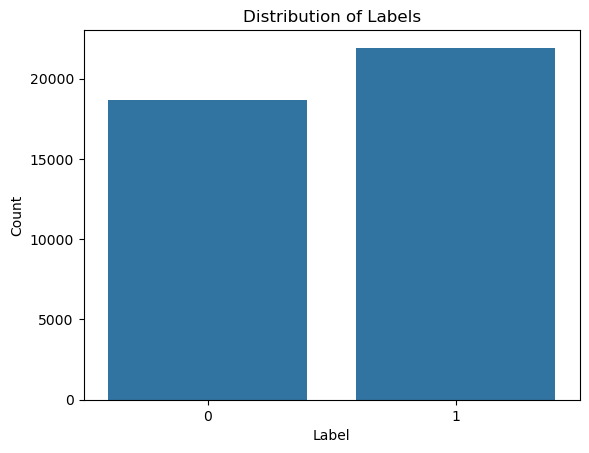

In [21]:
sns.countplot(data=df, x='Label')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

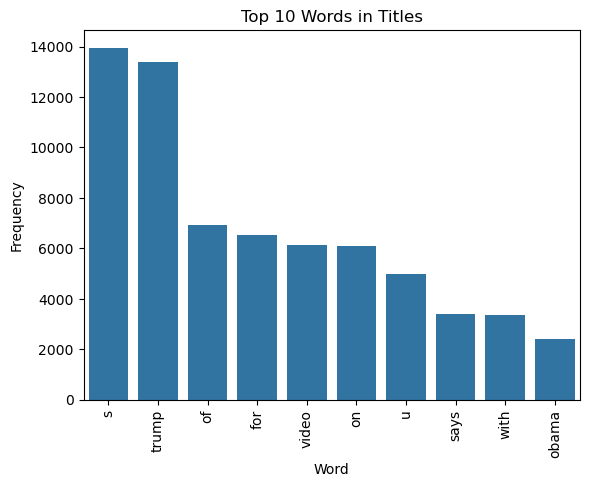

In [22]:
def preprocess_text(text):
    text = re.sub(r'\W+', ' ', text)
    tokens = text.lower().split()
    stopwords = set(['the', 'a', 'and', 'is', 'to', 'in'])
    return [word for word in tokens if word not in stopwords]

all_words = df['Title'].dropna().apply(preprocess_text).sum()
word_counts = Counter(all_words).most_common(10)

word_freq_df = pd.DataFrame(word_counts, columns=['word', 'frequency'])

sns.barplot(data=word_freq_df, x='word', y='frequency')
plt.title('Top 10 Words in Titles')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

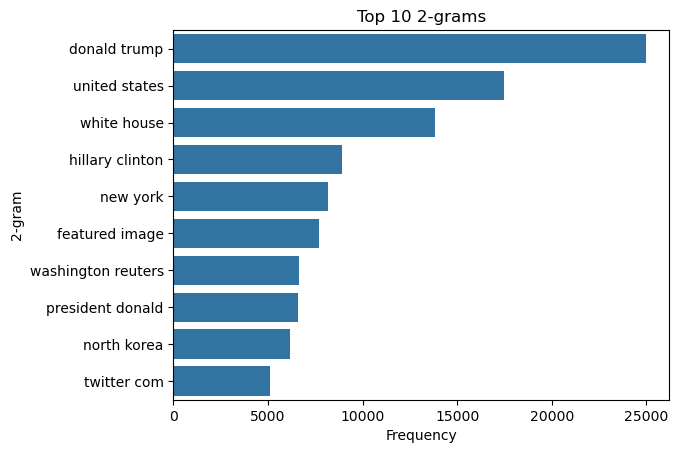

In [23]:
def plot_top_ngrams(text_data, n=2, top_n=10):

    """
    Function to extract and plot top n-grams.

    Params:
        text_data: str
        n: int, optional
        top_n: int, optional
    """
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    ngrams = vectorizer.fit_transform(text_data.dropna())
    ngram_counts = pd.DataFrame(ngrams.sum(axis=0), columns=vectorizer.get_feature_names_out(), index=['count']).T
    top_ngrams = ngram_counts.nlargest(top_n, 'count')

    sns.barplot(data=top_ngrams.reset_index(), x='count', y='index')
    plt.title(f'Top {top_n} {n}-grams')
    plt.xlabel('Frequency')
    plt.ylabel(f'{n}-gram')
    plt.show()

plot_top_ngrams(df['Text'], n=2, top_n=10)

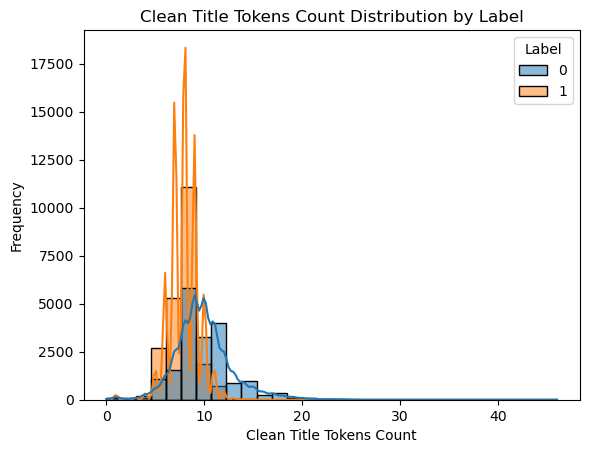

In [24]:
sns.histplot(data=df, x='Clean Title Tokens Count', hue='Label', bins=30, kde=True)
plt.title('Clean Title Tokens Count Distribution by Label')
plt.xlabel('Clean Title Tokens Count')
plt.ylabel('Frequency')
plt.show()

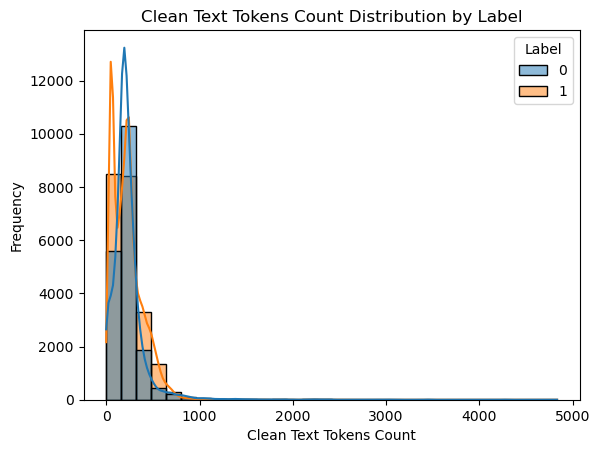

In [25]:
sns.histplot(data=df, x='Clean Text Tokens Count', hue='Label', bins=30, kde=True)
plt.title('Clean Text Tokens Count Distribution by Label')
plt.xlabel('Clean Text Tokens Count')
plt.ylabel('Frequency')
plt.show()

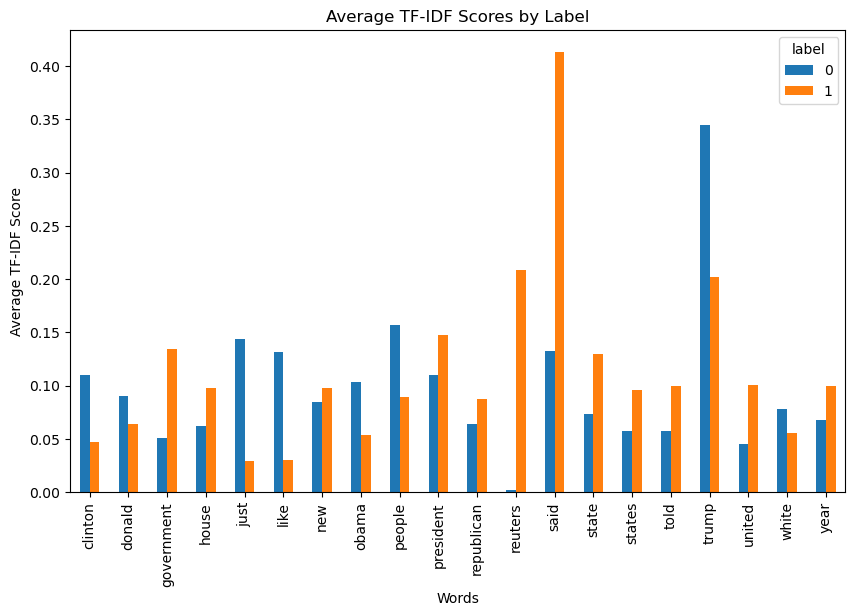

In [26]:
tfidf = TfidfVectorizer(stop_words='english', max_features=20)  # limit to 20 words for clarity
tfidf_matrix = tfidf.fit_transform(df['Text'].fillna(''))
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

# add label to the TF-IDF DataFrame
tfidf_df['label'] = df['Label']

# plot average TF-IDF scores by label for the top words
tfidf_avg = tfidf_df.groupby('label').mean().T
tfidf_avg.plot(kind='bar', figsize=(10, 6))
plt.title('Average TF-IDF Scores by Label')
plt.ylabel('Average TF-IDF Score')
plt.xlabel('Words')
plt.show()

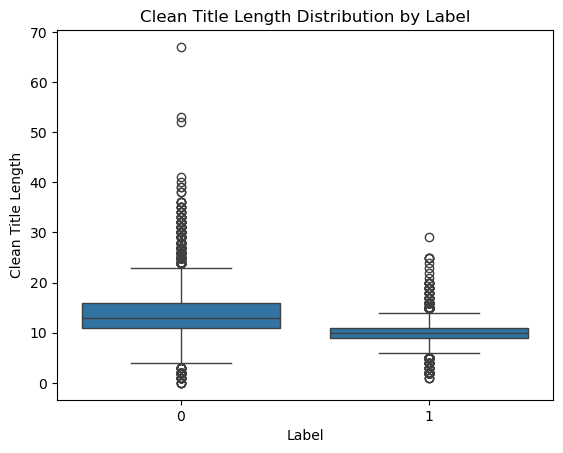

In [27]:
df['Clean Title Length'] = df['Clean Title'].apply(lambda x: len(x.split()))  # Calculer la longueur du titre
p = sns.boxplot(data=df, x='Label', y='Clean Title Length')
p.set(xlabel='Label', ylabel='Clean Title Length', title='Clean Title Length Distribution by Label')
plt.show()

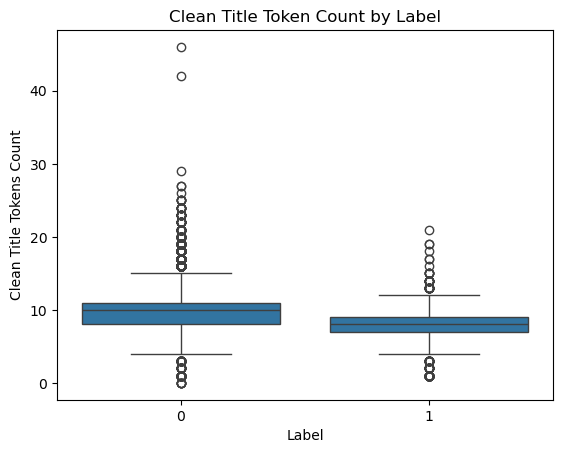

In [28]:
p = sns.boxplot(data=df, x='Label', y='Clean Title Tokens Count')
p.set(xlabel='Label', ylabel='Clean Title Tokens Count', title='Clean Title Token Count by Label')
plt.show()

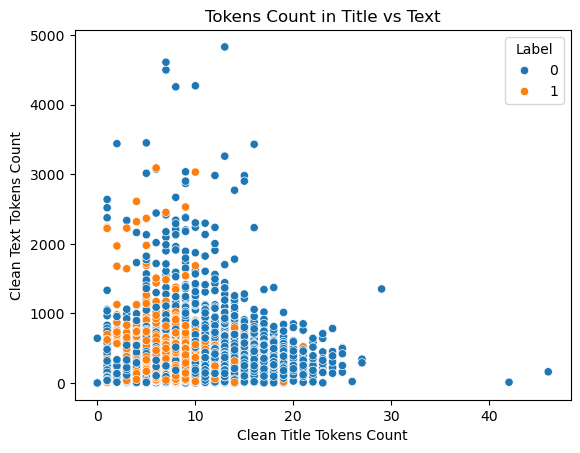

In [29]:
p = sns.scatterplot(data=df, x='Clean Title Tokens Count', y='Clean Text Tokens Count', hue='Label')
p.set(xlabel='Clean Title Tokens Count', ylabel='Clean Text Tokens Count', title='Tokens Count in Title vs Text')
plt.show()

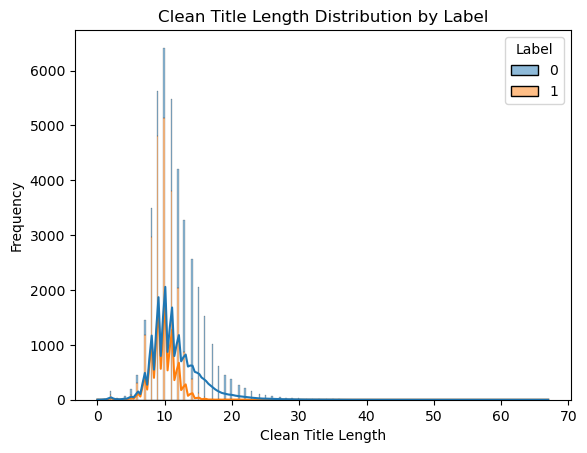

In [30]:
df['Clean Title Length'] = df['Clean Title'].apply(lambda x: len(x.split()))  # Longueur du titre
p = sns.histplot(df, x='Clean Title Length', hue='Label', multiple='stack', kde=True)
p.set(xlabel='Clean Title Length', ylabel='Frequency', title='Clean Title Length Distribution by Label')
plt.show()

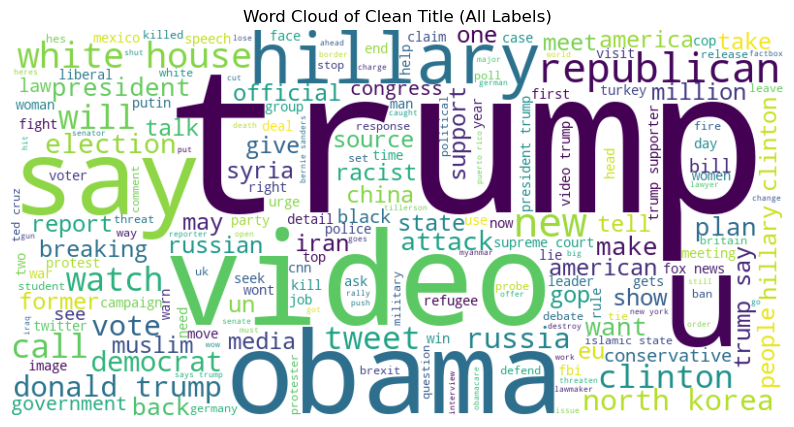

In [31]:
# Create a word cloud for the entire Clean Title column
wordcloud_clean_title = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['Clean Title']))

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_clean_title, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Clean Title (All Labels)')
plt.show()

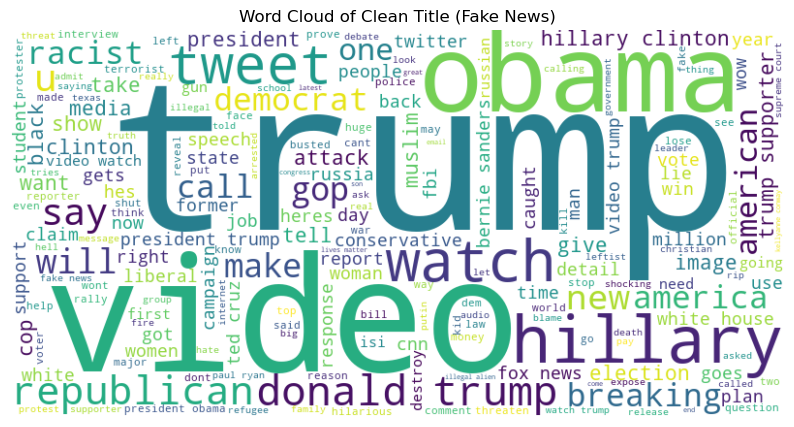

In [32]:
# Filter the rows where Label is 0 (Fake News)
fake_news_df = df[df['Label'] == 0]

# Create a word cloud for Clean Title with Label 0
wordcloud_fake_news = WordCloud(width=800, height=400, background_color='white').generate(' '.join(fake_news_df['Clean Title']))

# Display the word cloud for fake news
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_fake_news, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Clean Title (Fake News)')
plt.show()

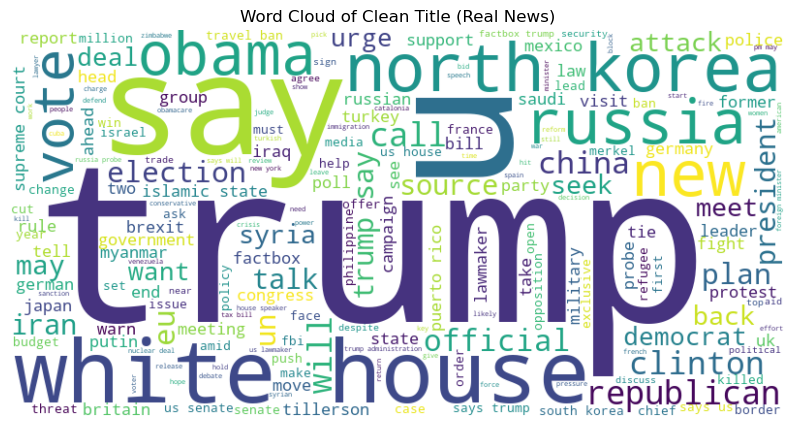

In [33]:
# Filter the rows where Label is 1 (Real News)
real_news_df = df[df['Label'] == 1]

# Create a word cloud for Clean Title with Label 1
wordcloud_real_news = WordCloud(width=800, height=400, background_color='white').generate(' '.join(real_news_df['Clean Title']))

# Display the word cloud for real news
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_real_news, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Clean Title (Real News)')
plt.show()

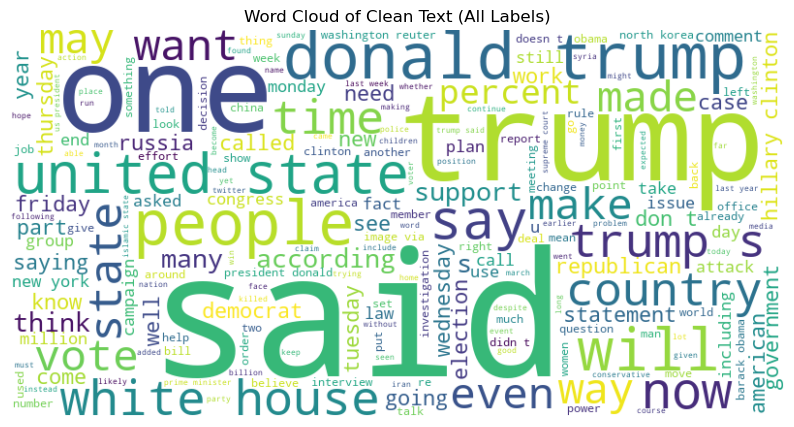

In [34]:
# Create a word cloud for the entire Clean Title column
wordcloud_clean_title = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['Clean Text']))

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_clean_title, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Clean Text (All Labels)')
plt.show()

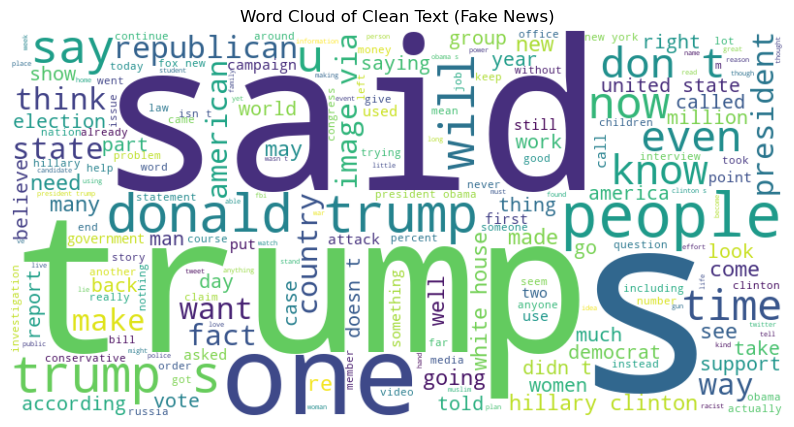

In [35]:
# Filter the rows where Label is 0 (Fake News)
fake_news_df = df[df['Label'] == 0]

# Create a word cloud for Clean Title with Label 0
wordcloud_fake_news = WordCloud(width=800, height=400, background_color='white').generate(' '.join(fake_news_df['Clean Text']))

# Display the word cloud for fake news
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_fake_news, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Clean Text (Fake News)')
plt.show()

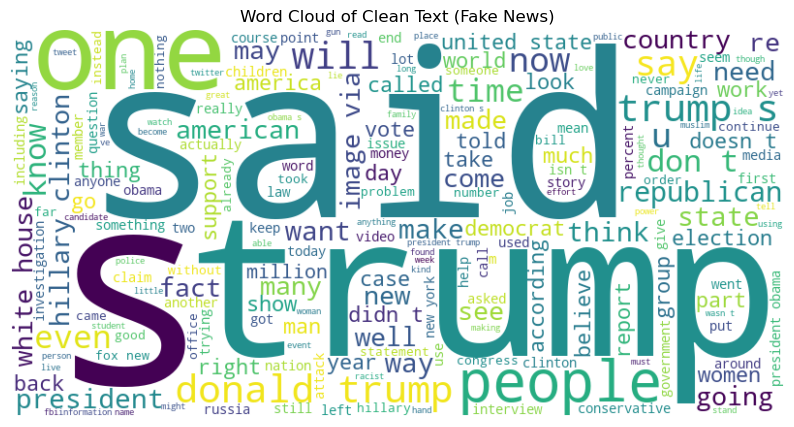

In [36]:
# Filter the rows where Label is 0 (Fake News)
fake_news_df = df[df['Label'] == 0]

# Create a word cloud for Clean Title with Label 0
wordcloud_fake_news = WordCloud(width=800, height=400, background_color='white').generate(' '.join(fake_news_df['Clean Text']))

# Display the word cloud for fake news
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_fake_news, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Clean Text (Fake News)')
plt.show()

In [37]:


# Filter the DataFrame for Fake News (Label 0) and Real News (Label 1)
fake_news_df = df[df['Label'] == 0]
real_news_df = df[df['Label'] == 1]

# Initialize CountVectorizer to count token frequency
vectorizer = CountVectorizer(stop_words='english')

# Count tokens for Fake News (Label 0)
fake_news_tokens = vectorizer.fit_transform(fake_news_df['Clean Title'])
fake_news_terms = pd.DataFrame(fake_news_tokens.toarray(), columns=vectorizer.get_feature_names_out())
fake_news_term_freq = fake_news_terms.sum(axis=0).sort_values(ascending=False)

# Convert the term frequencies into a list of tuples
fake_news_top_terms = list(fake_news_term_freq.head(25).items())

# Count tokens for Real News (Label 1)
real_news_tokens = vectorizer.fit_transform(real_news_df['Clean Title'])
real_news_terms = pd.DataFrame(real_news_tokens.toarray(), columns=vectorizer.get_feature_names_out())
real_news_term_freq = real_news_terms.sum(axis=0).sort_values(ascending=False)

# Convert the term frequencies into a list of tuples
real_news_top_terms = list(real_news_term_freq.head(25).items())

# Print Top 25 Used Terms in Fake News
print('Top 25 Used Terms in Fake News:')
print(fake_news_top_terms)

# Print Top 25 Used Terms in Real News
print('\nTop 25 Used Terms in Real News:')
print(real_news_top_terms)

Top 25 Used Terms in Fake News:
[('trump', 6080), ('video', 2987), ('watch', 1518), ('hillary', 1275), ('trumps', 1266), ('obama', 1252), ('just', 1248), ('clinton', 777), ('president', 770), ('donald', 762), ('gop', 686), ('new', 683), ('news', 662), ('white', 656), ('black', 627), ('breaking', 587), ('tweets', 531), ('gets', 482), ('media', 431), ('obamas', 426), ('muslim', 425), ('says', 425), ('house', 413), ('republicans', 406), ('campaign', 388)]

Top 25 Used Terms in Real News:
[('trump', 4837), ('says', 2969), ('house', 1434), ('north', 911), ('new', 897), ('white', 815), ('russia', 801), ('korea', 792), ('senate', 743), ('court', 708), ('trumps', 701), ('clinton', 667), ('republican', 633), ('state', 627), ('china', 613), ('tax', 607), ('obama', 602), ('deal', 549), ('vote', 543), ('election', 533), ('talks', 522), ('eu', 491), ('pm', 476), ('iran', 475), ('president', 467)]


## Initial Baseline Model

In [38]:
data = df[['Clean Text Tokens', 'Label']]
data.head()

,Clean Text Tokens,Label
0,"[washington, reuters, democratic, us, presiden...",1
1,"[moscow, reuters, proposal, convene, congress,...",1
2,"[baffling, fit, rage, oregon, state, police, o...",0
3,"[last, thing, politician, running, presidency,...",0
4,"[good, miss, mr, teleprompter, well, went, scr...",0


In [39]:
X = data['Clean Text Tokens']
y = data['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 43, stratify = data['Label'])

display(X_train.shape)
display(y_train.shape)
display(X_test.shape)
display(y_test.shape)

(30440,)

(30440,)

(10147,)

(10147,)

We will build 2 models:

* Multinomial Naive Bayes with Count Vectorizer
* Multinomial Naive Bayes with TF-IDF Vectorizer

## Model #1

In [40]:
pipeline_count = Pipeline([
    ('vectorizer', CountVectorizer(tokenizer=lambda x: x, lowercase=False)),  # Pass tokens as is
    ('model', MultinomialNB())
])

# Train the model
pipeline_count.fit(X_train, y_train)

/Users/tobiaspariente/anaconda3/envs/learn-env/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 CountVectorizer(lowercase=False,
                                 tokenizer=<function <lambda> at 0x338dbd8a0>)),
                ('model', MultinomialNB())])

In [41]:
y_pred_count = pipeline_count.predict(X_test)
print("Classification Report (Count Vectorizer):")
print(classification_report(y_test, y_pred_count))

Classification Report (Count Vectorizer):
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      4666
           1       0.95      0.94      0.95      5481

    accuracy                           0.94     10147
   macro avg       0.94      0.94      0.94     10147
weighted avg       0.94      0.94      0.94     10147



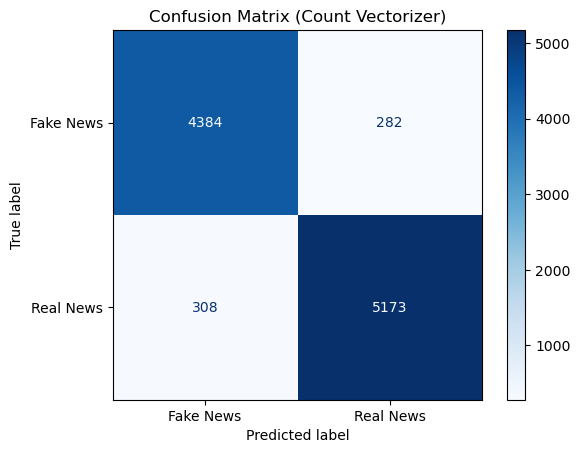

In [42]:
# Confusion Matrix Display
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_count, 
    display_labels=['Fake News', 'Real News'], 
    cmap='Blues'
)
plt.title("Confusion Matrix (Count Vectorizer)")
plt.show()

In [43]:
# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred_count)
precision = precision_score(y_test, y_pred_count)
recall = recall_score(y_test, y_pred_count)
f1 = f1_score(y_test, y_pred_count)
cohen_kappa = cohen_kappa_score(y_test, y_pred_count)
mcc = matthews_corrcoef(y_test, y_pred_count)

# Store metrics in a DataFrame
metrics_table = pd.DataFrame({
    "Metric": [
        "Accuracy Score", 
        "Precision Score", 
        "Recall Score", 
        "F1 Score", 
        "Cohen's Kappa Score", 
        "Matthew's Correlation Coefficient"
    ],
    "Value": [
        accuracy, 
        precision, 
        recall, 
        f1, 
        cohen_kappa, 
        mcc
    ]
})

# Display the metrics table
print(metrics_table)

                              Metric     Value
0                     Accuracy Score  0.941855
1                    Precision Score  0.948304
2                       Recall Score  0.943806
3                           F1 Score  0.946050
4                Cohen's Kappa Score  0.883003
5  Matthew's Correlation Coefficient  0.883015


## Model #2

In [44]:
pipeline_tfidf = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)),  # Pass tokens as is
    ('model', MultinomialNB())
])

# Train the model
pipeline_tfidf.fit(X_train, y_train)

/Users/tobiaspariente/anaconda3/envs/learn-env/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(lowercase=False,
                                 tokenizer=<function <lambda> at 0x338dbc9a0>)),
                ('model', MultinomialNB())])

In [45]:
# Predictions for TF-IDF
y_pred_tfidf = pipeline_tfidf.predict(X_test)

# Classification Report
print("Classification Report (TF-IDF Vectorizer):")
print(classification_report(y_test, y_pred_tfidf))

Classification Report (TF-IDF Vectorizer):
              precision    recall  f1-score   support

           0       0.95      0.86      0.91      4666
           1       0.89      0.96      0.93      5481

    accuracy                           0.92     10147
   macro avg       0.92      0.91      0.92     10147
weighted avg       0.92      0.92      0.92     10147



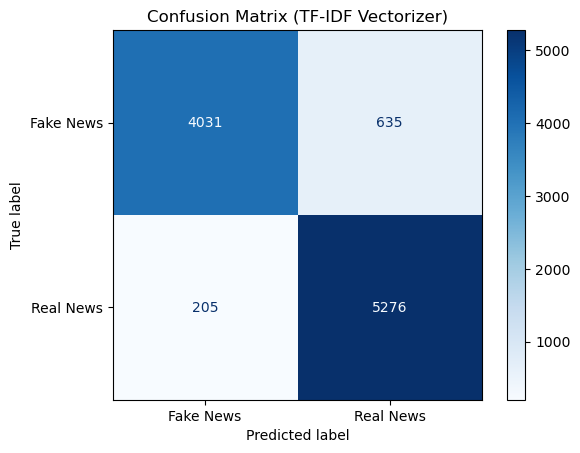

In [46]:
# Confusion Matrix Display
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_tfidf, 
    display_labels=['Fake News', 'Real News'], 
    cmap='Blues'
)
plt.title("Confusion Matrix (TF-IDF Vectorizer)")
plt.show()

In [47]:
# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred_tfidf)
precision = precision_score(y_test, y_pred_tfidf)
recall = recall_score(y_test, y_pred_tfidf)
f1 = f1_score(y_test, y_pred_tfidf)
cohen_kappa = cohen_kappa_score(y_test, y_pred_tfidf)
mcc = matthews_corrcoef(y_test, y_pred_tfidf)

# Store metrics in a DataFrame
metrics_table_tfidf = pd.DataFrame({
    "Metric": [
        "Accuracy Score", 
        "Precision Score", 
        "Recall Score", 
        "F1 Score", 
        "Cohen's Kappa Score", 
        "Matthew's Correlation Coefficient"
    ],
    "Value": [
        accuracy, 
        precision, 
        recall, 
        f1, 
        cohen_kappa, 
        mcc
    ]
})

# Display the metrics table
print(metrics_table_tfidf)


                              Metric     Value
0                     Accuracy Score  0.917217
1                    Precision Score  0.892573
2                       Recall Score  0.962598
3                           F1 Score  0.926264
4                Cohen's Kappa Score  0.832209
5  Matthew's Correlation Coefficient  0.835296


## Compare our 2 Models

Accuracy score:
* Multinomial Naive Bayes with Count Vectorizer - 0.94
* Multinomial Naive Bayes with TF-IDF Vectorizer - 0.92

Precision score:
* Multinomial Naive Bayes with Count Vectorizer - 0.95
* Multinomial Naive Bayes with TF-IDF Vectorizer - 0.89

Recall score:
* Multinomial Naive Bayes with Count Vectorizer - 0.94
* Multinomial Naive Bayes with TF-IDF Vectorizer - 0.96

F1 score:
* Multinomial Naive Bayes with Count Vectorizer - 0.95
* Multinomial Naive Bayes with TF-IDF Vectorizer - 0.93

Cohen's Kappa Score:
* Multinomial Naive Bayes with Count Vectorizer - 0.88
* Multinomial Naive Bayes with TF-IDF Vectorizer - 0.83

Matthew's Correlation Coefficient:
* Multinomial Naive Bayes with Count Vectorizer - 0.88
* Multinomial Naive Bayes with TF-IDF Vectorizer - 0.84

Before Tuning:

Count Vectorizer Model outperforms the TF-IDF Vectorizer Model across most metrics, including Accuracy (0.94 vs. 0.92), Precision (0.95 vs. 0.89), Recall (0.94 vs. 0.96), F1 score (0.95 vs. 0.93), Cohen's Kappa (0.88 vs. 0.83), and Matthew's Correlation Coefficient (0.88 vs. 0.84).
The TF-IDF Vectorizer performs better in Recall, which indicates that it is more sensitive to identifying all relevant instances (higher recall means fewer false negatives), but it sacrifices Precision.

## Tuning Model #1.1 Alpha = 0.001

In [48]:
# Label encoding the target variable
le = LabelEncoder()

y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)


In [49]:
# Define the pipeline with Count Vectorizer and Multinomial Naive Bayes
model_alpha_001 = Pipeline([
    ('vectorizer', CountVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x, lowercase=False)),
    ('classifier', MultinomialNB(alpha=0.001))
])

# Fit the model
model_alpha_001.fit(X_train, y_train_enc)

/Users/tobiaspariente/anaconda3/envs/learn-env/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 CountVectorizer(lowercase=False,
                                 preprocessor=<function <lambda> at 0x38096ba60>,
                                 tokenizer=<function <lambda> at 0x38096b9c0>)),
                ('classifier', MultinomialNB(alpha=0.001))])

## Tuning Model #1.2 Alpha = 0.01

In [50]:
model_alpha_01 = Pipeline([
    ('vectorizer', CountVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x, lowercase=False)),
    ('classifier', MultinomialNB(alpha=0.01))
])

# Fit the model
model_alpha_01.fit(X_train, y_train_enc)

/Users/tobiaspariente/anaconda3/envs/learn-env/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 CountVectorizer(lowercase=False,
                                 preprocessor=<function <lambda> at 0x38096bc40>,
                                 tokenizer=<function <lambda> at 0x38096b920>)),
                ('classifier', MultinomialNB(alpha=0.01))])

## Tuning Model #1.3 Alpha = 0.1

In [51]:
model_alpha_1 = Pipeline([
    ('vectorizer', CountVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x, lowercase=False)),
    ('classifier', MultinomialNB(alpha=0.1))
])

# Fit the model
model_alpha_1.fit(X_train, y_train_enc)

/Users/tobiaspariente/anaconda3/envs/learn-env/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 CountVectorizer(lowercase=False,
                                 preprocessor=<function <lambda> at 0x3389c72e0>,
                                 tokenizer=<function <lambda> at 0x3808a0180>)),
                ('classifier', MultinomialNB(alpha=0.1))])

## Comparison Tuned Models #1

In [52]:
# Create a DataFrame to store the metrics
metrics_table_tune_model1 = pd.DataFrame({
    "Model": ["Alpha = 0.001", "Alpha = 0.01", "Alpha = 0.1"],
    "Accuracy": [model_alpha_001.score(X_test, y_test_enc), 
                 model_alpha_01.score(X_test, y_test_enc), 
                 model_alpha_1.score(X_test, y_test_enc)],
    "Cohen's Kappa": [cohen_kappa_score(y_test_enc, model_alpha_001.predict(X_test)),
                      cohen_kappa_score(y_test_enc, model_alpha_01.predict(X_test)),
                      cohen_kappa_score(y_test_enc, model_alpha_1.predict(X_test))],
    "Matthew's Correlation": [matthews_corrcoef(y_test_enc, model_alpha_001.predict(X_test)),
                              matthews_corrcoef(y_test_enc, model_alpha_01.predict(X_test)),
                              matthews_corrcoef(y_test_enc, model_alpha_1.predict(X_test))]
})

# Display the metrics table
print(metrics_table_tune_model1)

           Model  Accuracy  Cohen's Kappa  Matthew's Correlation
0  Alpha = 0.001  0.946388       0.892293               0.892562
1   Alpha = 0.01  0.945797       0.891074               0.891270
2    Alpha = 0.1  0.944910       0.889244               0.889353


## Tuning Model #2.1 Alpha = 0.001

In [53]:
model_alpha_001_tfidf = Pipeline([
    ('vectorizer', TfidfVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x, lowercase=False)),
    ('classifier', MultinomialNB(alpha=0.001))
])

# Fit the model
model_alpha_001_tfidf.fit(X_train, y_train_enc)

/Users/tobiaspariente/anaconda3/envs/learn-env/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(lowercase=False,
                                 preprocessor=<function <lambda> at 0x38096b880>,
                                 tokenizer=<function <lambda> at 0x38096bb00>)),
                ('classifier', MultinomialNB(alpha=0.001))])

## Tuning Model #2.2 Alpha = 0.01

In [54]:
model_alpha_01_tfidf = Pipeline([
    ('vectorizer', TfidfVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x, lowercase=False)),
    ('classifier', MultinomialNB(alpha=0.01))
])

# Fit the model
model_alpha_01_tfidf.fit(X_train, y_train_enc)

/Users/tobiaspariente/anaconda3/envs/learn-env/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(lowercase=False,
                                 preprocessor=<function <lambda> at 0x3808a00e0>,
                                 tokenizer=<function <lambda> at 0x3808a09a0>)),
                ('classifier', MultinomialNB(alpha=0.01))])

## Tuning Model #2.3 Alpha = 0.1

In [55]:
model_alpha_1_tfidf = Pipeline([
    ('vectorizer', TfidfVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x, lowercase=False)),
    ('classifier', MultinomialNB(alpha=0.1))
])

# Fit the model
model_alpha_1_tfidf.fit(X_train, y_train_enc)

/Users/tobiaspariente/anaconda3/envs/learn-env/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(lowercase=False,
                                 preprocessor=<function <lambda> at 0x338dbcd60>,
                                 tokenizer=<function <lambda> at 0x338dbe0c0>)),
                ('classifier', MultinomialNB(alpha=0.1))])

## Comparison Tuned Models #2

In [56]:
# Create a DataFrame to store the metrics
metrics_table_tune_model2 = pd.DataFrame({
    "Model": ["Alpha = 0.001", "Alpha = 0.01", "Alpha = 0.1"],
    "Accuracy": [model_alpha_001_tfidf.score(X_test, y_test_enc), 
                 model_alpha_01_tfidf.score(X_test, y_test_enc), 
                 model_alpha_1_tfidf.score(X_test, y_test_enc)],
    "Cohen's Kappa": [cohen_kappa_score(y_test_enc, model_alpha_001_tfidf.predict(X_test)),
                      cohen_kappa_score(y_test_enc, model_alpha_01_tfidf.predict(X_test)),
                      cohen_kappa_score(y_test_enc, model_alpha_1_tfidf.predict(X_test))],
    "Matthew's Correlation": [matthews_corrcoef(y_test_enc, model_alpha_001_tfidf.predict(X_test)),
                              matthews_corrcoef(y_test_enc, model_alpha_01_tfidf.predict(X_test)),
                              matthews_corrcoef(y_test_enc, model_alpha_1_tfidf.predict(X_test))]
})

# Display the metrics table
print(metrics_table_tune_model2)

           Model  Accuracy  Cohen's Kappa  Matthew's Correlation
0  Alpha = 0.001  0.939391       0.878168               0.878304
1   Alpha = 0.01  0.936927       0.873108               0.873130
2    Alpha = 0.1  0.932887       0.864774               0.864834


## Final Comparison of All of our Tuned Models

Accuracy score:
* Multinomial Naive Bayes with Count Vectorizer with alpha = 0.001 - 0.95
* Multinomial Naive Bayes with Count Vectorizer with alpha = 0.01 - 0.94
* Multinomial Naive Bayes with Count Vectorizer with alpha = 0.1 - 0.94
* Multinomial Naive Bayes with TF-IDF Vectorizer with alpha = 0.001 - 0.94
* Multinomial Naive Bayes with TF-IDF Vectorizer with alpha = 0.01 - 0.94
* Multinomial Naive Bayes with TF-IDF Vectorizer with alpha = 0.1 - 0.93

Cohen's Kappa Score:
* Multinomial Naive Bayes with Count Vectorizer with alpha = 0.001  - 0.89
* Multinomial Naive Bayes with Count Vectorizer with alpha = 0.01 - 0.89
* Multinomial Naive Bayes with Count Vectorizer with alpha = 0.1 - 0.89
* Multinomial Naive Bayes with TF-IDF Vectorizer with alpha = 0.001 - 0.88
* Multinomial Naive Bayes with TF-IDF Vectorizer with alpha = 0.01 - 0.97
* Multinomial Naive Bayes with TF-IDF Vectorizer with alpha = 0.1 - 0.86

Matthew's Correlation Coefficient:
* Multinomial Naive Bayes with Count Vectorizer with alpha = 0.001 - 0.89
* Multinomial Naive Bayes with Count Vectorizer with alpha = 0.01 - 0.89
* Multinomial Naive Bayes with Count Vectorizer with alpha = 0.1 - 0.89
* Multinomial Naive Bayes with TF-IDF Vectorizer with alpha = 0.001 - 0.88
* Multinomial Naive Bayes with TF-IDF Vectorizer with alpha = 0.01 - 0.87
* Multinomial Naive Bayes with TF-IDF Vectorizer with alpha = 0.1 - 0.86

After Tuning:

* Count Vectorizer with Alpha = 0.001:
The accuracy improves to 0.95, maintaining a high Cohen's Kappa (0.89) and Matthew's Correlation Coefficient (0.89).

* TF-IDF Vectorizer with Alpha = 0.01: 
This configuration gives the best Cohen's Kappa (0.97) and reasonable Accuracy (0.94), but the Matthew's Correlation Coefficient drops to 0.87, which is still quite solid.

Key Insights:

* Count Vectorizer with Alpha = 0.001 appears to be the best model based on the overall consistency of metrics like Accuracy (0.95), Cohen's Kappa (0.89), and Matthew's Correlation Coefficient (0.89). This model also maintains a good balance across both Precision and Recall.

* TF-IDF Vectorizer with Alpha = 0.01 improves significantly in Cohen's Kappa (0.97), but the drop in Matthew's Correlation Coefficient (0.87) and the slightly lower Accuracy (0.94) suggests that it's more sensitive to changes in hyperparameters, which might make it less stable in certain contexts.

## Final Choice of my Model

I am chosing Multinomial Naive Bayes with Count Vectorizer and Alpha = 0.001 as the final model. 

Here's why:

* It offers higher overall performance across multiple metrics like Accuracy, Cohen's Kappa, and Matthew's Correlation Coefficient.
* It strikes a good balance between Precision and Recall, maintaining strong performance in both without sacrificing too much on either side.
* The stability of performance across different alpha values (with minor variation in tuning) supports its robustness.

At the end, Multinomial Naive Bayes with Count Vectorizer and Alpha = 0.001 is the most reliable choice based on the evaluation metrics, and it will likely provide the most consistent and well-rounded performance across my task.

## Pickle my Final Pipeline

In [57]:
def preprocessor(text):
    return text

def tokenizer(text):
    return text

# Define the pipeline with CountVectorizer and Multinomial Naive Bayes
pickle_model_alpha_001 = Pipeline([
    ('vectorizer', CountVectorizer(preprocessor=preprocessor, tokenizer=tokenizer, lowercase=False)),
    ('classifier', MultinomialNB(alpha=0.001))
])

# Label encoding the target variable
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Fit the model
pickle_model_alpha_001.fit(X_train, y_train_enc)

# Save the final model
with open('final_model.pkl', 'wb') as f:
    pickle.dump(pickle_model_alpha_001, f)

/Users/tobiaspariente/anaconda3/envs/learn-env/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## Deployment with Streamlit

In [58]:
# run this in a terminal
# streamlit run /Users/tobiaspariente/Desktop/PYTHON/PHASE_5/app.py